In [1]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler
import torchvision.models as models
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import MultiStepLR, ReduceLROnPlateau
#torch.multiprocessing.set_start_method("spawn")
import cnn
from sklearn.model_selection import KFold

import os
import numpy as np
import pandas as pd
from utils import progress_bar
from skimage import transform as tf

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
BASE_dir = 'data/processed/'

train = pd.read_json(BASE_dir + 'train.json')
test = pd.read_json(BASE_dir + 'test.json')

In [33]:
#prepare data
use_cuda= True if torch.cuda.is_available() else False
#use_cuda =False
#dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor 
dtype = torch.FloatTensor 
data=  pd.read_json(BASE_dir + 'train.json')

class iceberg_dataset(Dataset):
    def __init__(self, data,transform): #data: 1604 * 3 *75* 75
        self.data =data
        self.transform=transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        img=  self.data[idx]
        img = torch.from_numpy(img).type(dtype)
        img= self.transform(img)

        return img

def stack(row):
    return np.stack(row[['c1','c2','c3']]).reshape(3,75,75)

def raw_to_numpy(data):
    img = []
    data['c1'] = data['band_1'].apply(np.array)
    data['c2'] = data['band_2'].apply(np.array)
    data['c3'] = (data['c1'] + data['c2'])/2
#     data['c3'] = (data['c1'] + data['c2'])/2
    for _, row in data.iterrows():
        img.append(stack(row))
    return np.stack(img)

def transform_compute(img):
    train_mean = img.mean(axis=(0,2,3))
    train_std = img.std(axis=(0,2,3))
    return train_mean, train_std

train_X = raw_to_numpy(data)#.transpose(0,2,3,1)
train_X.shape     #1604 * 3 *75* 75   N*c*H*W
train_y = data['is_iceberg'].values # if iceberg then 1
test_X = raw_to_numpy(test)#.transpose(0,2,3,1)
train_X.shape     #1604 * 3 *75* 75   N*c*H*W
X_all = np.concatenate((train_X,test_X))

temp = []
for i in X_all:
    temp1= []
    for j in i:
        temp1.append(tf.rescale(j,64/75,mode='constant'))
    temp.append(np.stack(temp1))
    
X_all_64 = np.stack(temp)

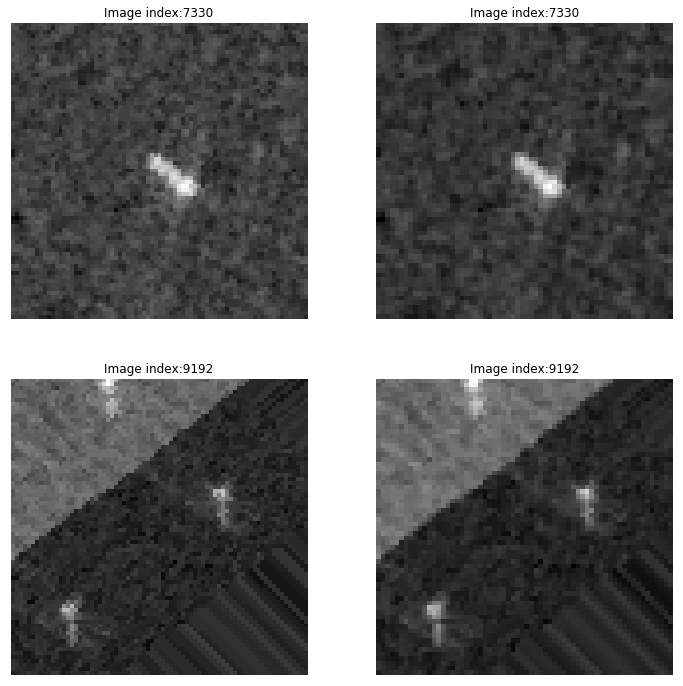

In [44]:
len(train) # 1604 obs
train.head(3)
#randomly draw some of them

fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2,2)

index = np.random.choice(list(range(len(X_all))),size=2, replace=False)
for num,i in enumerate(index):
    for j in range(2):
        ax = plt.subplot(gs[num*2+j])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title('Image index:%d' % i)
        ax.set_aspect('equal')
        if j ==0:
            plt.imshow(X_all[i][2])
        if j ==1:
            plt.imshow(X_all_64[i][2])

In [41]:
#X_all[1].shape
X_all[i].transpose(1,2,0).shape

(75, 75, 3)

In [52]:
# train_mean, train_std = transform_compute(X_all)
# train_transform = T.Compose([
#     T.Normalize(train_mean, train_std)
# ])

# train_dataset = iceberg_dataset(X_all, transform=train_transform)
# train_loader = DataLoader(train_dataset, batch_size=64,shuffle=True)


train_mean, train_std = transform_compute(X_all_64)
train_transform = T.Compose([
    T.Normalize(train_mean, train_std)
])

train_dataset = iceberg_dataset(X_all_64, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=64,shuffle=True)

In [59]:
batch_size =64
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(3,32,3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.MaxPool2d(2,2),   # batch x 64 x 14 x 14
                        nn.Conv2d(32,64,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)   # batch x 64 x 14 x 14
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),  # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1),  # batch x 64 x 7 x 7
                        nn.ReLU(),
                        nn.BatchNorm2d(256),
                        nn.MaxPool2d(2,2)
        )
        
                
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(-1, 256*4*4)
        return out
    
encoder = Encoder().cuda()


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,kernel_size=3,stride=2,padding =1, output_padding = 1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,2,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,32,3,2,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,3,3,2,1,1),
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = x.view(-1,256,4,4)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

decoder = Decoder().cuda()

In [71]:
for image in train_loader:
    image = Variable(image).cuda()
    
    output = encoder(image)
    output = decoder(output)
    print(output.size())
    break
parameters = list(encoder.parameters())+ list(decoder.parameters())
loss_func = nn.MSELoss()

# optimizer = torch.optim.Adam(parameters, lr=0.01)
optimizer = torch.optim.SGD(parameters, momentum=0.9 ,lr=0.01,nesterov = True)
scheduler = MultiStepLR(optimizer, [25,50,75,100,125,150,175], gamma=0.1)

torch.Size([64, 3, 64, 64])


In [72]:
epoch=200
for i in range(epoch):
    total =0
    loss_avg = 0
    for j,image in enumerate(train_loader):
        image = Variable(image).cuda()
        image_n=image
        #image_n = Variable(image_n).cuda()
        #label = Variable(label.float()).cuda()
        optimizer.zero_grad()
        output = encoder(image_n)
        output = decoder(output)
        loss = loss_func(output,image)
        loss.backward()
        optimizer.step()
        total += output.size()[0]
        loss_avg += loss.cpu().data[0] *output.size()[0]        
        progress_bar(j, len(train_loader), 'Loss: %.3f' % (loss_avg/total))

[========= 157/157 ======>]Step: 0ms| Tot: 6s7ms|Loss: 0.4306
[========= 157/157 ======>]Step: 0ms| Tot: 6s7ms|Loss: 0.430
[========= 157/157 ======>]Step: 0ms| Tot: 6s7ms|Loss: 0.429
[========= 157/157 ======>]Step: 0ms| Tot: 6s7ms|Loss: 0.429
[========= 157/157 ======>]Step: 0ms| Tot: 6s7ms|Loss: 0.430
[========= 157/157 ======>]Step: 0ms| Tot: 6s7ms|Loss: 0.429
[========= 157/157 ======>]Step: 0ms| Tot: 6s7ms|Loss: 0.429
[========= 157/157 ======>]Step: 0ms| Tot: 6s7ms|Loss: 0.429
[========= 157/157 ======>]Step: 0ms| Tot: 6s7ms|Loss: 0.429
[========= 157/157 ======>]Step: 0ms| Tot: 6s7ms|Loss: 0.429
[========= 157/157 ======>]Step: 0ms| Tot: 6s7ms|Loss: 0.429
[========= 157/157 ======>]Step: 0ms| Tot: 6s7ms|Loss: 0.429
[========= 157/157 ======>]Step: 0ms| Tot: 6s8ms|Loss: 0.429
[========= 157/157 ======>]Step: 0ms| Tot: 6s8ms|Loss: 0.429
[========= 157/157 ======>]Step: 0ms| Tot: 6s8ms|Loss: 0.429
[========= 157/157 ======>]Step: 0ms| Tot: 6s8ms|Loss: 0.428
[========= 157/157 ====

[========= 157/157 ======>]Step: 0ms| Tot: 6s7ms|Loss: 0.423
[========= 157/157 ======>]Step: 0ms| Tot: 6s8ms|Loss: 0.423
[========= 157/157 ======>]Step: 0ms| Tot: 6s8ms|Loss: 0.423
[========= 157/157 ======>]Step: 0ms| Tot: 6s7ms|Loss: 0.423
[========= 157/157 ======>]Step: 0ms| Tot: 6s8ms|Loss: 0.423
[========= 157/157 ======>]Step: 0ms| Tot: 6s8ms|Loss: 0.423
[========= 157/157 ======>]Step: 0ms| Tot: 6s7ms|Loss: 0.423
[========= 157/157 ======>]Step: 0ms| Tot: 6s7ms|Loss: 0.423
[========= 157/157 ======>]Step: 0ms| Tot: 6s8ms|Loss: 0.423
[========= 157/157 ======>]Step: 0ms| Tot: 6s8ms|Loss: 0.423
[========= 157/157 ======>]Step: 0ms| Tot: 6s8ms|Loss: 0.423
[========= 157/157 ======>]Step: 0ms| Tot: 6s8ms|Loss: 0.423
[========= 157/157 ======>]Step: 0ms| Tot: 6s8ms|Loss: 0.423
[========= 157/157 ======>]Step: 0ms| Tot: 6s8ms|Loss: 0.423
[========= 157/157 ======>]Step: 0ms| Tot: 6s8ms|Loss: 0.423
[========= 157/157 ======>]Step: 0ms| Tot: 6s8ms|Loss: 0.423
[========= 157/157 =====

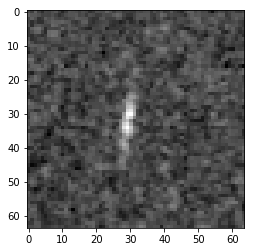

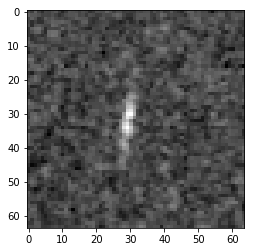

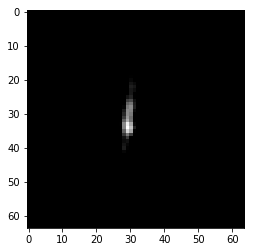

In [74]:
img = image[12].cpu()
input_img = image_n[12].cpu()
output_img = output[12].cpu()

origin = img.data.numpy()
inp = input_img.data.numpy()
out = output_img.data.numpy()

plt.imshow(origin[0],cmap='gray')
plt.show()

plt.imshow(inp[0],cmap='gray')
plt.show()

plt.imshow(out[0],cmap="gray")
plt.show()

In [87]:
#X_all_64 = np.stack(temp)

train_mean, train_std = transform_compute(X_all_64)
train_transform = T.Compose([
    T.Normalize(train_mean, train_std)
])

train_dataset = iceberg_dataset(X_all_64, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=64,shuffle=False)




result = []
result2 = []
for j,image in enumerate(train_loader):
    image = Variable(image).cuda()
    image_n=image
    #image_n = Variable(image_n).cuda()
    #label = Variable(label.float()).cuda()
    optimizer.zero_grad()
    output = encoder(image_n)
    array1= output.view(-1,256*4*4).cpu().data.numpy()
    result.append(array1)
    
    output = decoder(output)
    array2= output.view(-1,3,64,64).cpu().data.numpy()
    result2.append(array2)
    if j %50==0:
        print(j)

0
50
100
150


In [86]:
result2[0].shape

(64, 3, 64, 64)

In [75]:
torch.save(encoder.state_dict(), 'encoder_v1.pth')
torch.save(decoder.state_dict(), 'decoder_v1.pth')

In [96]:
interm = np.concatenate(result)
new_img = np.concatenate(result2)

In [102]:
#X_all DataFrameatenate((train_X,test_X))
# X_intermediate = pd.DataFrame()
# X_intermediate['id']= data['id']
# X_intermediate['inc_angle']= data['inc_angle']
# X_intermediate['value'] = 0
# for i in range(1604):
#     X_intermediate.iloc[i,2]= interm[i]

with open('DAE_data/interm1.npy', 'wb') as f:
    np.save(f,interm)
with open('DAE_data/new_img1.npy', 'wb') as f:
    np.save(f,new_img)


# sub=pd.DataFrame()
# sub['id'] = 

In [106]:
# np.stack(result).shape
np.concatenate(result).shape
# for i in result:
#     print(i.shape)
X_intermediate.iloc[i,1]

X_all_64_test=  X_all_64
X_all_64_test[0][0][0,0]=10000
# print(X_all_64_test[0])
train_dataset = iceberg_dataset(X_all_64, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=64,shuffle=False)
for j,image in enumerate(train_loader):
    print(image[0])


(0 ,.,.) = 
  1.9507e+03 -1.0522e+00 -1.3628e+00  ...  -7.4981e-01 -8.2780e-01 -1.5774e+00
 -1.2506e+00 -1.0464e+00 -1.4228e+00  ...  -8.4206e-01 -1.1372e+00 -1.8411e+00
 -1.0950e+00 -9.0147e-01 -9.0669e-01  ...  -8.6875e-01 -1.1454e+00 -1.6253e+00
                 ...                   ⋱                   ...                
 -1.0874e+00 -1.2872e+00 -1.4155e+00  ...  -1.1135e+00 -9.2720e-01 -9.1744e-01
 -1.6626e+00 -1.2061e+00 -1.4412e+00  ...  -1.2394e+00 -9.3848e-01 -9.7928e-01
 -1.3512e+00 -9.4286e-01 -1.2707e+00  ...  -1.1070e+00 -1.0502e+00 -1.1695e+00

(1 ,.,.) = 
 -6.3422e-01 -1.2123e+00 -1.5236e+00  ...  -1.0172e+00 -1.0433e+00 -6.1186e-01
 -1.6111e+00 -2.0259e+00 -1.5224e+00  ...  -1.9302e+00 -1.2591e+00 -5.7746e-01
 -1.6142e+00 -1.6668e+00 -1.1275e+00  ...  -1.2330e+00 -1.4410e+00 -1.0599e+00
                 ...                   ⋱                   ...                
 -9.1326e-01 -1.3012e+00 -2.0037e+00  ...  -5.9563e-01 -4.3723e-01 -5.4468e-01
 -9.6245e-01 -9.7548e-01 -


(0 ,.,.) = 
  6.6437e-01  6.7623e-01  5.4282e-01  ...   1.6526e-01  6.6437e-02  6.6319e-01
  9.8085e-01  8.2084e-01  4.2520e-01  ...   3.7914e-01  4.3827e-01  8.4611e-01
  8.0394e-01  8.5356e-01  4.5079e-01  ...   2.0557e-01  5.2705e-01  1.0122e+00
                 ...                   ⋱                   ...                
  6.6612e-01  4.1714e-02  3.3799e-01  ...   6.0129e-01  9.7577e-01  4.8996e-01
  6.8082e-01 -7.8244e-02 -2.1916e-01  ...   9.0995e-01  9.6477e-01  3.4363e-01
  6.7942e-01 -1.0002e-01 -3.4022e-01  ...   5.8248e-01  7.9423e-01  3.5833e-01

(1 ,.,.) = 
 -9.3268e-01 -5.1943e-01 -7.6946e-01  ...  -7.6075e-01 -5.7754e-01 -3.3574e-01
 -9.9950e-01 -1.0104e+00 -8.8775e-01  ...  -2.6456e-01 -1.4121e-01 -7.7799e-01
 -7.9083e-01 -8.2061e-01 -9.9835e-01  ...  -2.3592e-01 -4.3471e-01 -7.2647e-01
                 ...                   ⋱                   ...                
 -1.5674e+00 -9.6661e-01 -2.1955e-01  ...  -8.2477e-01 -6.8443e-01 -6.5582e-01
 -1.0258e+00 -1.5884e+00 -


(0 ,.,.) = 
  3.3628e-01  3.3627e-01  3.5395e-01  ...   9.9574e-01  8.5051e-01  6.4695e-01
  3.3628e-01  3.3627e-01  5.4223e-01  ...   9.9574e-01  8.5051e-01  4.8531e-01
  3.3628e-01  3.3627e-01  5.4223e-01  ...   9.9574e-01  8.5051e-01  4.8531e-01
                 ...                   ⋱                   ...                
 -6.2675e-01 -5.0076e-01 -3.5231e-01  ...  -6.0960e-01 -8.9367e-01 -6.8988e-01
 -1.3249e-01 -4.7697e-01 -4.8808e-01  ...   3.5038e-02  2.2762e-01 -1.3667e-01
 -7.4334e-01 -6.4983e-01 -1.8194e-01  ...  -2.8909e-02 -1.4114e-01 -3.6528e-01

(1 ,.,.) = 
  1.7610e+00  1.5040e+00  8.1639e-01  ...   1.8465e+00  1.5929e+00  1.5059e+00
  1.7610e+00  1.5040e+00  1.3713e+00  ...   1.8465e+00  1.5929e+00  1.6939e+00
  1.7610e+00  1.5040e+00  1.3713e+00  ...   1.8465e+00  1.5929e+00  1.6939e+00
                 ...                   ⋱                   ...                
 -7.1164e-01  1.8266e-01  1.8741e-01  ...  -1.7840e-01 -2.7754e-01 -2.3266e-01
 -2.5901e-01  2.0439e-01  


(0 ,.,.) = 
 -4.6591e-01 -4.4938e-01 -4.3896e-01  ...  -5.1557e-01 -8.1726e-01 -6.3489e-01
 -6.1050e-01 -5.5408e-01 -5.9381e-01  ...  -1.8745e-01 -3.7482e-01 -2.0974e-01
 -3.9658e-01 -4.1905e-01 -5.8784e-01  ...  -7.7284e-02 -9.5894e-04 -6.2673e-01
                 ...                   ⋱                   ...                
 -1.1428e+00 -1.4418e+00 -1.0185e+00  ...  -1.0271e+00 -1.0271e+00 -1.0271e+00
 -1.1428e+00 -1.4418e+00 -1.0185e+00  ...  -1.0271e+00 -1.0271e+00 -1.0271e+00
 -1.5186e+00 -9.9952e-01 -1.0185e+00  ...  -1.0271e+00 -1.0271e+00 -1.0271e+00

(1 ,.,.) = 
  2.1215e-01  2.5285e-01  1.9992e-02  ...   6.3227e-02 -8.7509e-01 -4.3273e-01
 -4.6890e-01  2.9228e-01  6.5511e-02  ...  -9.0682e-02  1.6209e-01  1.0870e-01
 -1.6954e-01 -1.3825e-01 -1.3868e-01  ...   5.8399e-01  3.0200e-01 -8.3133e-02
                 ...                   ⋱                   ...                
 -7.2746e-01 -4.9249e-01 -6.4317e-01  ...  -4.1385e-01 -4.1385e-01 -4.1385e-01
 -7.2746e-01 -4.9249e-01 -

In [ ]:
##For continue training
net = cnn.plain_cnn(num_classes=2)
 
net.load_state_dict(torch.load('cnn_loss.pth'))


criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.00175, nesterov= True)
scheduler = ReduceLROnPlateau(optimizer, 'max', patience =15,min_lr= 0.0001)
#5e-3 86
if use_cuda:
    criterion.cuda()
    net.cuda()

result = train(epoch=250,early_stopping= 20)


# test_set = pd.read_json(BASE_dir + 'test.json')
# test_X = raw_to_numpy(test_set)
# test_X.shape 
# fake_label = np.zeros(len(test_X))

# test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform,test=True)

# test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)
# result = []
# for i in range(10):
#     train(epoch=1)

#     prob = [] 
#     net.eval()
#     for k, (val_x, val_y) in enumerate(test_loader):
#         if use_cuda:
#             val_x, val_y = val_x.cuda(), val_y.cuda()
#         x = Variable(val_x)
#         y = Variable(val_y)
#         out = net(x)
#         #prevent overflow
#         temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
#         ans= temp[:,1]/(temp.sum(axis=1))
#         prob.append(ans)
#         #print(out.size())
#         progress_bar(k, len(test_loader))
#     result.append(np.concatenate(prob))

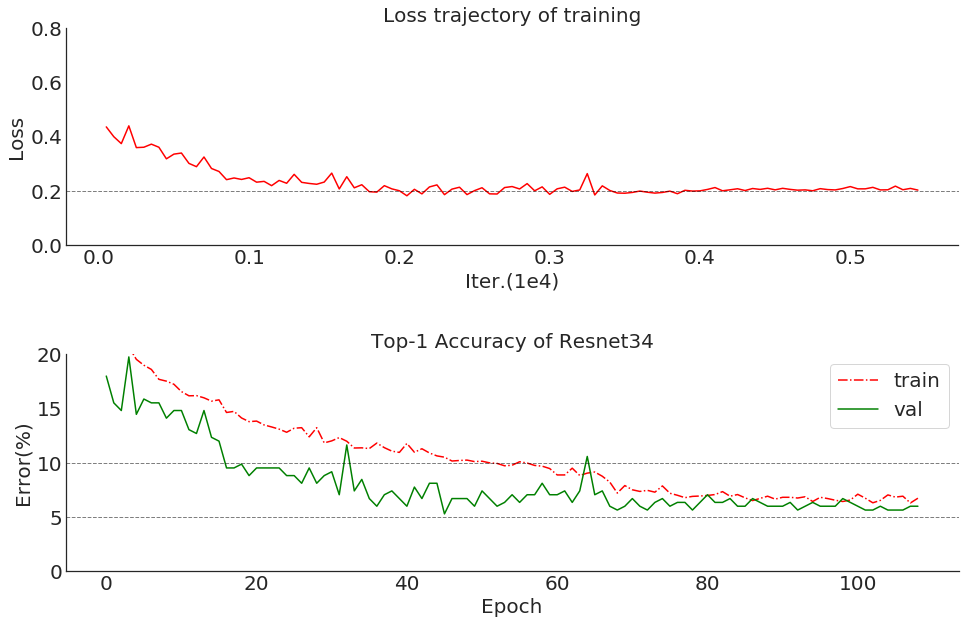

In [27]:
plt.style.use('seaborn-white')
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels

gs = gridspec.GridSpec(2,1)
gs.update(hspace=0.5)
fig = plt.figure(figsize=(16,10))
fig1 = fig.add_subplot(gs[0,0])
fig2 = fig.add_subplot(gs[1,0])
fig1.spines['right'].set_visible(False)
fig1.spines['top'].set_visible(False)
# for item in [fig1.xaxis.label, fig1.yaxis.label,fig2.xaxis.label, fig2.yaxis.label]:
#     item.set_fontsize(10)


# fig1.plot([i * 0.005 for i in range(1,len(train_data['loss_hist'])+1)],train_data['loss_hist'],color='black')
fig1.plot([i * 0.005 for i in range(1,len(train_data['val_loss_hist'])+1)],train_data['val_loss_hist'],color='red')
fig1.set(title= 'Loss trajectory of training',ylabel='Loss',xlabel='Iter.(1e4)',ylim=(0,0.8))
fig1.axhline(y=[0.2],alpha=0.5, linestyle='--',color='k',linewidth=1)

fig2.plot([100-i for i in train_data['train_acc_hist']], color='red',linestyle='-.',label = 'train')
fig2.plot([100-i for i in train_data['val_acc_hist']], color='green',linestyle='-',label='val')
fig2.legend(frameon=True)
fig2.spines['right'].set_visible(False)
fig2.spines['top'].set_visible(False)
fig2.axhline(y=[5],alpha=0.5, linestyle='--',color='k',linewidth=1)
fig2.axhline(y=[10],alpha=0.5, linestyle='--',color='k',linewidth=1)
_=fig2.set(title= 'Top-1 Accuracy of Resnet34',ylim=(0,20),xlabel='Epoch',ylabel='Error(%)')

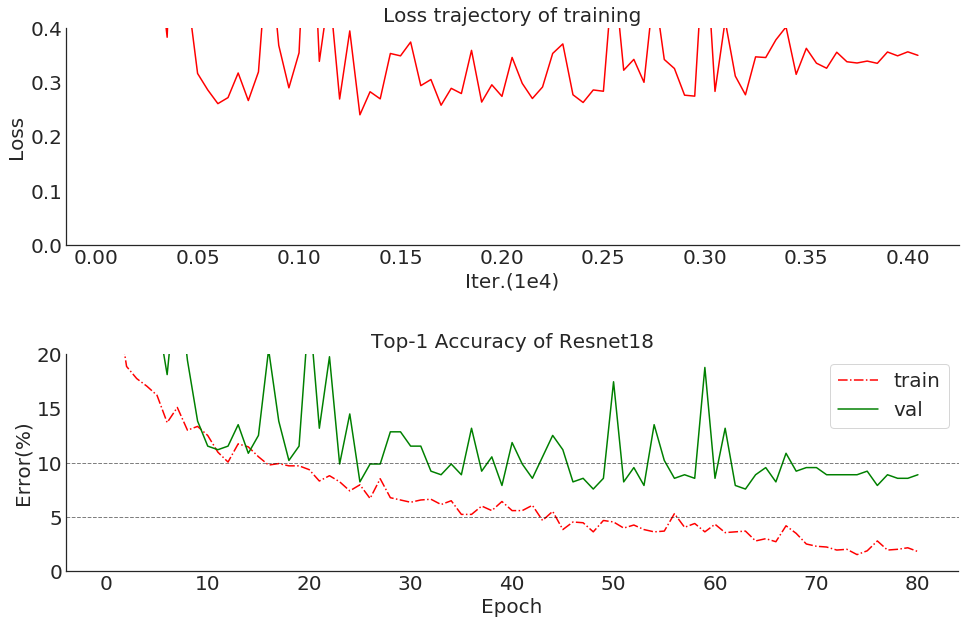

In [12]:
plt.style.use('seaborn-white')
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels

gs = gridspec.GridSpec(2,1)
gs.update(hspace=0.5)
fig = plt.figure(figsize=(16,10))
fig1 = fig.add_subplot(gs[0,0])
fig2 = fig.add_subplot(gs[1,0])
fig1.spines['right'].set_visible(False)
fig1.spines['top'].set_visible(False)
# for item in [fig1.xaxis.label, fig1.yaxis.label,fig2.xaxis.label, fig2.yaxis.label]:
#     item.set_fontsize(10)


# fig1.plot([i * 0.005 for i in range(1,len(train_data['loss_hist'])+1)],train_data['loss_hist'],color='black')
fig1.plot([i * 0.005 for i in range(1,len(train_data['val_loss_hist'])+1)],train_data['val_loss_hist'],color='red')
fig1.set(title= 'Loss trajectory of training',ylabel='Loss',xlabel='Iter.(1e4)',ylim=(0,0.4))

fig2.plot([100-i for i in train_data['train_acc_hist']], color='red',linestyle='-.',label = 'train')
fig2.plot([100-i for i in train_data['val_acc_hist']], color='green',linestyle='-',label='val')
fig2.legend(frameon=True)
fig2.spines['right'].set_visible(False)
fig2.spines['top'].set_visible(False)
fig2.axhline(y=[5],alpha=0.5, linestyle='--',color='k',linewidth=1)
fig2.axhline(y=[10],alpha=0.5, linestyle='--',color='k',linewidth=1)
_=fig2.set(title= 'Top-1 Accuracy of Resnet18',ylim=(0,20),xlabel='Epoch',ylabel='Error(%)')

In [18]:
out1 = torch.cat((out.data,out.data),1)
out1.size()
# out
criterion(out,y.long())
type(predicted)
type(y.data)
#predicted.eq(y.data).cpu().sum()

torch.cuda.DoubleTensor

In [77]:
k =np.stack(result).mean(axis=0)
# #sub.shapesub.to_csv('submission2.csv',index=False)
# result[1].shape
# np.concatenate(prob).shape

In [9]:
sub=pd.DataFrame()
sub['id'] = test['id']
sub['is_iceberg'] =  np.concatenate(prob)
sub.shape
sub.to_csv('submissioniu.csv',index=False)

In [41]:
temp= pd.read_csv('submission3.csv') #0.0001 wd one
sub['is_iceberg2'] = temp['is_iceberg']
sub.corr()

,is_iceberg,is_iceberg2
is_iceberg,1.000000,0.886197
is_iceberg2,0.886197,1.000000


In [20]:
sub=pd.DataFrame()
sub['id'] = test['id']
sub['is_iceberg'] = temp12['is_iceberg']#temp11.mean(axis=1)#temp11['is_iceberg']
sub.shape
sub.to_csv('submissionpp.csv',index=False)